# **1 Data loading and rocessing**

In [64]:
import numpy as np
import matplotlib.pyplot as plt
def load_data(root="FashionMNIST0.5.npz"):
    dataset = np.load(root)
    Xtr = dataset['Xtr'] 
    Ytr = dataset['Str'] 
    Xts = dataset['Xts']
    Yts = dataset['Yts'] 
    print("======没有subset and sampling=====")
    print("training data: ",Xtr.shape) 
    print("noise label: ",Ytr.shape) 
    print("test data: ",Xts.shape) 
    print("clean label: ",Yts.shape)
    return Xtr, Ytr, Xts, Yts

Xtr, Ytr, Xts, Yts = load_data("FashionMNIST0.5.npz")
Xtr_2, Ytr_2, Xts_2, Yts_2 = load_data(root="FashionMNIST0.6.npz")
Xtr_3, Ytr_3, Xts_3, Yts_3 = load_data(root="CIFAR.npz")

======没有subset and sampling=====
training data:  (18000, 28, 28)
noise label:  (18000,)
test data:  (3000, 28, 28)
clean label:  (3000,)
======没有subset and sampling=====
training data:  (18000, 28, 28)
noise label:  (18000,)
test data:  (3000, 28, 28)
clean label:  (3000,)
======没有subset and sampling=====
training data:  (15000, 32, 32, 3)
noise label:  (15000,)
test data:  (3000, 32, 32, 3)
clean label:  (3000,)


In [98]:
import os
import copy
import random
import numpy as np
import pandas as pd
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models
import torchvision.transforms


class DatasetArray(Dataset):
    def __init__(self, data, labels=None, transform=None):
        if labels != None:
            self.data_arr = np.asarray(data).astype(np.float32)
            self.label_arr = np.asarray(labels).astype(np.long)
        else:
            tmp_arr = np.asarray(data)
            self.data_arr = tmp_arr[:,:-1].astype(np.float32)
            self.label_arr = tmp_arr[:,-1].astype(np.long)
        self.transform = transform
    
    def __len__(self):
        return len(self.data_arr)
    
    def __getitem__(self, index):
     
        data = self.data_arr[index]
        label = self.label_arr[index]
        
        if self.transform is not None:
            data = self.transform(data)
            
        return (data, label)
    
    
def train_val_random_split(data, label, fracs=[0.8,0.2]):

    assert len(fracs) == 2 
    assert sum(fracs) == 1
    assert all(frac > 0 for frac in fracs)
    n = len(data)
    subset_lens = [int(n*frac) for frac in fracs]
    idxs = list(range(n))
    random.shuffle(idxs)
    data = np.array(data)
    label = np.array(label)
    new_data = []
    new_label = []
    start_idx = 0
    for subset_len in subset_lens:
        end_idx = start_idx + subset_len
        cur_idxs = idxs[start_idx:end_idx]
        new_data.append(data[cur_idxs,:].tolist())
        new_label.append(label[cur_idxs].tolist())
        start_idx = end_idx
    return new_data, new_label
    
def get_loader(batch_size =144, num_workers = 1, train_val_split = [0.8,0.2], data=None, label=None):

    [train_data, val_data],[train_label, val_label] = train_val_random_split(data, label, fracs = train_val_split) 
    train_data = DatasetArray(data = train_data, labels = train_label)
    val_data = DatasetArray(data = val_data, labels = val_label)


    train_loader = DataLoader(
        train_data,
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
    )

    val_loader = DataLoader(
        val_data,
        batch_size=100,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader

0  =  (144, 1, 28, 28)
torch.Size([144])
torch.Size([100, 28, 28])
torch.Size([100])


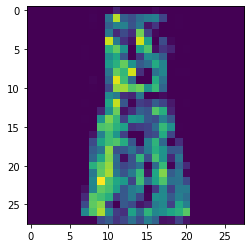

In [99]:
train_loader, val_loader= get_loader(
        batch_size = 144, 
        num_workers = 1,
        train_val_split = [0.8,0.2],
        data = Xtr,
        label = Ytr
    )

for i, (data,label) in enumerate(train_loader):
    data = np.expand_dims(data, 1)      # if numpy array
   # tensor = torch.tensor.unsqueeze(1)  # if torch tensor
    print(i," = ",data.shape)
    plt.imshow(data[0][0])
    print(label.shape)
    break
for i, (data,label) in enumerate(val_loader,0):
    print(data.shape)
    print(label.shape)
    break

# **2 Some useful function**

In [100]:
def seed_torch(seed=1029):
    r"""Fix all random seeds for repeating the expriement result."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # If multi-GPUs are used. 
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def one_hot_embedding(labels, num_classes):
    r"""Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 


def accuracy(output, target, topk=(1,)):
    r"""Computes the precision@k for the specified values of k."""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count
        


In [101]:
def eval_flip_rates(model= CNNmodel,name= "trained_model_1"):
    global config
    global train_loader

    model.load_state_dict(torch.load(os.path.join(name, 'model_best.pth'))["state_dict"])
    model.eval()
    pos_condition_p = []
    for step, (data, targets) in enumerate(train_loader):
        
        data = data.to(device)
        data = data.unsqueeze(1)
        labels = targets.numpy()

        with torch.no_grad():
            outputs = model(data)

        one_hot_labels = one_hot_embedding(targets,3).numpy()
        probs = F.softmax(outputs, dim=1).cpu().data.numpy()
        data = data.cpu().numpy()
        pos_condition_p += probs[:,1].tolist() 
        
    pos_condition_p = sorted(pos_condition_p)

    negative_flip_rate, positive_flip_rate = pos_condition_p[0], 1-pos_condition_p[-1]
    print('estimated negative flip rate：', est_neg_flip_rate)
    print('estimated positive flip rate：', est_pos_flip_rate)


# **3 DATASET: FshionMINIST0.5**

# **3.1 DataLoder**

In [65]:
# load data FashionMINIST0.5 
train_loader, val_loader= get_loader(
    batch_size = 100, 
    num_workers = 1,
    train_val_split = [0.8,0.2],
    data = Xtr,
    label = Ytr
)

# load test data FashionMINIST0.5
test_data = DatasetArray(data = Xts, labels = Yts.tolist())
test_loader = DataLoader(
    test_data,
    batch_size=100, 
    shuffle=True, 
    num_workers=1, 
)

# **3.2 Two models (used both in FashionMINIST0.5 and 0.6 dataset)**

In [102]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.bc1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        # Max pool 1
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.bc2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)

        self.dropout = nn.Dropout(p=0.5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32*4*4, 3)


    def forward(self, x):

        # Convolution 1
        out = self.cnn1(x)
        out = self.bc1(out)
        out = self.relu1(out)

        # Avg pool 1
        out = self.avgpool1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.bc2(out)
        out = self.relu2(out)

        # Avg pool 2
        out = self.avgpool2(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        # Linear function (readout)
        out = F.softmax(self.fc1(out))

        return out

class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=3)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out



In [103]:
def train(epoch, model, optimizer, criterion, train_loader):
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    # swith model to to train mode
    model.train()
    for step, (data, targets) in enumerate(train_loader):
        
        data = torch.tensor(np.expand_dims(data, 1))
    #    tensor = torch.tensor.unsqueeze(1)
        
        data = data.to(device)
        targets = targets.to(device)

        preds = model(data)
        
        loss = criterion(preds, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        [top1_acc] = accuracy(preds.data, targets.data, topk=(1,)) 
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

    return top1_acc_meter.avg
    
    
def validate_and_test(epoch, model, criterion, val_loader, datatype=1):
    
    acc_list = []

    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    matrix = torch.Tensor([[0.5,0.2,0.3],[0.3,0.5,0.2],[0.2,0.3,0.5]]).to(device)
    matrix_inverse = torch.inverse(matrix).to(device)

    matrix_2 = torch.Tensor([[0.4,0.3,0.3],[0.3,0.4,0.3],[0.3,0.3,0.4]]).to(device)
    matrix_inverse_2 = torch.inverse(matrix_2).to(device)

    model.eval()
    for step, (data, targets) in enumerate(val_loader): 
        
        data = torch.tensor(np.expand_dims(data, 1))
        
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)

        # predict
        with torch.no_grad():
            preds = model(data)
            preds = preds.to(device)

        # forward
        loss = criterion(preds, targets)      
        
        if datatype == 0:
            [top1_acc] = accuracy(preds.data, targets.data, topk=(1,)) 
        if datatype == 1:
            clean = torch.mm(matrix_inverse, preds.T).T.to(device)
            [top1_acc] = accuracy(clean.data, targets.data, topk=(1,)) 

        if datatype == 2:   
            clean = torch.mm(matrix_inverse_2, preds.T).T.to(device)          
            [top1_acc] = accuracy(clean.data, targets.data, topk=(1,)) 

        acc_list.append(top1_acc.item())
        std = torch.std(torch.Tensor(acc_list))
        
        min_batch_size = data.size(0)  
        top1_acc_meter.update(top1_acc.item(), min_batch_size) 
        loss_meter.update(loss.item(), min_batch_size)

    return top1_acc_meter.avg, std



# **3.3 The first classfier for FashionMINIST0.5**

epoch 0 :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Accuracy  39.44444444444444
val Accuracy  45.638888888888886


epoch 1 :
Train Accuracy  45.80555555555556
val Accuracy  46.52777777777778


epoch 2 :
Train Accuracy  46.673611111111114
val Accuracy  46.5


epoch 3 :
Train Accuracy  46.729166666666664
val Accuracy  46.888888888888886


epoch 4 :
Train Accuracy  47.24305555555556
val Accuracy  46.80555555555556


epoch 5 :
Train Accuracy  47.25
val Accuracy  46.77777777777778


epoch 6 :
Train Accuracy  47.44444444444444
val Accuracy  47.02777777777778


epoch 7 :
Train Accuracy  47.81944444444444
val Accuracy  46.97222222222222


epoch 8 :
Train Accuracy  47.71527777777778
val Accuracy  47.166666666666664


epoch 9 :
Train Accuracy  47.68055555555556
val Accuracy  47.388888888888886


epoch 10 :
Train Accuracy  47.68055555555556
val Accuracy  47.5


epoch 11 :
Train Accuracy  47.604166666666664
val Accuracy  47.55555555555556


epoch 12 :
Train Accuracy  48.21527777777778
val Accuracy  47.47222222222222


epoch 13 :
Train Accurac

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test mean: 94.23333333333333
Test standard tensor(2.3879)


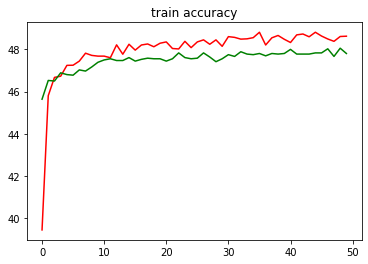

In [15]:
### FashionMINIST0.5 CNN
def run_CNN():
    global device
    global model
    global CNNmodel

    mean_train = 0
    mean_val = 0
    best_top1_acc = 0
    losses_train = []
    losses_val= []
    datatype = 1
    epoch = 50
    std = 0

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'    
    
    # set random seed
    seed_torch(1)

    # create output directory
    outdir = 'trained_model_1'
    if not os.path.exists(outdir):
        os.makedirs(outdir)


    # CNNmodel
    CNNmodel = CNNModel()
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        CNNmodel = nn.DataParallel(CNNmodel)
    CNNmodel.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(  
        params = CNNmodel.parameters(),
        lr = 0.001, 
        momentum = 0.9,
        weight_decay = 1e-5
    )

    for epoch in range(epoch):

        print("epoch", epoch, ":")

        #train
        train_acc = train(epoch, CNNmodel, optimizer, criterion, train_loader)
        print("Train Accuracy ",train_acc)
        mean_train += train_acc

        #validation
        val_acc, std = validate_and_test(epoch, CNNmodel, criterion, val_loader,datatype=0)
        print("val Accuracy ",val_acc)
        mean_val += val_acc

        losses_train.append(train_acc)
        losses_val.append(val_acc)

        print("\n")

        # save the best model so far
        if (val_acc > best_top1_acc):
            state = OrderedDict([
              #  ('config', config),
                ('state_dict', CNNmodel.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', val_acc),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = val_acc

    print("train mean:", mean_train/(epoch+1))
    print("val mean:", mean_val/(epoch+1))

    plt.title('train accuracy')
    plt.plot(np.arange(len(losses_train)), losses_train, color='red',label='train')
    plt.plot(np.arange(len(losses_val)),losses_val, color='green', label='val') 

    test_accurac, std = validate_and_test(1, CNNmodel, criterion, test_loader, datatype = 0)
    print("Test mean:",test_accurac) 
    print("Test standard", std )

    test_accuracy, std1 = validate_and_test(1, CNNmodel, criterion, test_loader, datatype = 1)
    print("Test mean:",test_accuracy) 
    print("Test standard", std1)
               
run_CNN()



In [85]:
eval_flip_rates(CNNmodel,"trained_model_1")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


estimated negative flip rate： 0.2541327178478241
estimated positive flip rate： 0.5483614504337311


# **3.4 The second classfier for FashionMINIST0.5**

epoch 0 :
Train Accuracy  44.46527777777778
val Accuracy  47.333333333333336
epoch 1 :
Train Accuracy  47.486111111111114
val Accuracy  48.083333333333336
epoch 2 :
Train Accuracy  47.50694444444444
val Accuracy  47.388888888888886
epoch 3 :
Train Accuracy  48.09722222222222
val Accuracy  47.05555555555556
epoch 4 :
Train Accuracy  48.729166666666664
val Accuracy  47.583333333333336
epoch 5 :
Train Accuracy  49.020833333333336
val Accuracy  48.47222222222222
epoch 6 :
Train Accuracy  48.513888888888886
val Accuracy  47.361111111111114
epoch 7 :
Train Accuracy  48.833333333333336
val Accuracy  48.083333333333336
epoch 8 :
Train Accuracy  48.826388888888886
val Accuracy  47.166666666666664
epoch 9 :
Train Accuracy  48.94444444444444
val Accuracy  47.166666666666664
train mean: 48.042361111111106
val mean: 47.56944444444444
Test mean: 89.03333333333333
Test standard:  tensor(3.5378)
Test: 92.13333333333334
Test standard:  tensor(2.8252)


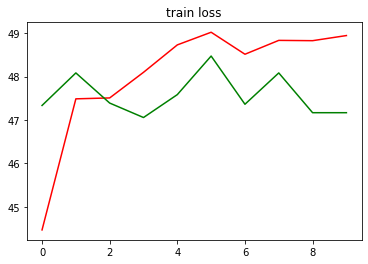

In [22]:
### FashionMINIST0.5 FashionCNN
def run_FashionCNN():
    global device
    global model
    global Fashion_model

    mean_train = 0
    mean_val = 0
    best_top1_acc = 0
    losses_train = []
    losses_val= []
    datatype = 1
    epoch = 10

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
    # set random seed
    seed_torch(1)

    # create output directory
    outdir = 'trained_model_2'
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    ## FashionCNN
    Fashion_model = FashionCNN()
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        Fashion_model = nn.DataParallel(Fashion_model)
    Fashion_model.to(device)


    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(  
        params = Fashion_model.parameters(),
        lr = 0.001, 
        momentum = 0.9,
        weight_decay = 1e-5
    )


    for epoch in range(epoch):

        print("epoch", epoch, ":")

        #train
        train_acc = train(epoch, Fashion_model, optimizer, criterion, train_loader)
        print("Train Accuracy ",train_acc)
        mean_train += train_acc

        #validation
        val_acc, s = validate_and_test(epoch, Fashion_model, criterion, val_loader, datatype=0)
        print("val Accuracy ",val_acc)
        mean_val += val_acc

        losses_train.append(train_acc)
        losses_val.append(val_acc)

        # save the best model so far
        if (val_acc > best_top1_acc):
            state = OrderedDict([
            #    ('config', config),
                ('state_dict', Fashion_model.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', val_acc),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = val_acc
    
    print("train mean:", mean_train/(epoch+1))
    print("val mean:", mean_val/(epoch+1))

    plt.title('train loss')
    plt.plot(np.arange(len(losses_train)), losses_train, color='red',label='train')
    plt.plot(np.arange(len(losses_val)),losses_val, color='green', label='val')  

    test_accurac, std = validate_and_test(1, Fashion_model, criterion, test_loader, datatype = 0)
    print("Test mean:",test_accurac) 
    print("Test standard: ", std)

    test_accuracy, st = validate_and_test(1, Fashion_model, criterion, test_loader, datatype=1)
    print("Test:",test_accuracy)
    print("Test standard: ", st)

run_FashionCNN()

In [86]:
eval_flip_rates(Fashion_model,"trained_model_2")

estimated negative flip rate： 0.2541327178478241
estimated positive flip rate： 0.5483614504337311


# **4 DATASET: FashionMINIST0.6**




# **4.1 Dataloader**

In [96]:
# load data FashionMINIST0.6
train_loader, val_loader= get_loader(
    batch_size = 100, 
    num_workers = 1,
    train_val_split = [0.8,0.2],
    data = Xtr_2,
    label = Ytr_2
)

# load test data FashionMINIST0.6
test_data = DatasetArray(data = Xts_2, labels = Yts_2.tolist())
test_loader = DataLoader(
    test_data,
    batch_size=100, 
    shuffle=True, 
    num_workers=1, 
)

# **4.2 The first classfier for FashionMINIST0.6**

epoch 0 :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Accuracy  37.854165153503416
val Accuracy  46.611111111111114


epoch 1 :
Train Accuracy  44.819442672729494
val Accuracy  47.05555555555556


epoch 2 :
Train Accuracy  45.73610919952392
val Accuracy  47.416666666666664


epoch 3 :
Train Accuracy  46.29860942840576
val Accuracy  47.69444444444444


epoch 4 :
Train Accuracy  46.756942901611325
val Accuracy  47.69444444444444


epoch 5 :
Train Accuracy  46.506942710876466
val Accuracy  47.69444444444444


epoch 6 :
Train Accuracy  47.00694286346435
val Accuracy  47.888888888888886


epoch 7 :
Train Accuracy  46.83333179473877
val Accuracy  48.02777777777778


epoch 8 :
Train Accuracy  46.88194278717041
val Accuracy  48.05555555555556


epoch 9 :
Train Accuracy  47.23610942840576
val Accuracy  48.19444444444444


train mean: 45.593053894042974
val mean: 47.63333333333333
Test mean: 90.2
Test standard:  tensor(2.2652)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test mean: 90.2
Test standard:  tensor(2.7342)


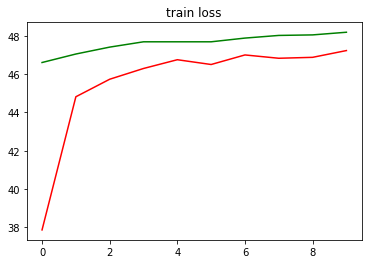

In [104]:
### FashionMINIST0.6 CNN
def run_CNN_2():
    global device
    global model
    global CNNmodel_2

    mean_train = 0
    mean_val = 0
    best_top1_acc = 0
    losses_train = []
    losses_val= []
    datatype = 0
    epoch = 10

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'    
    
    # set random seed
    seed_torch(1)

    # create output directory
    outdir = 'trained_model_3'
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # CNNmodel
    CNNmodel_2 = CNNModel()
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        CNNmodel_2 = nn.DataParallel(CNNmodel_2)
    CNNmodel_2.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(  
        params = CNNmodel_2.parameters(),
        lr = 0.001, 
        momentum = 0.9,
        weight_decay = 1e-5
    )

    for epoch in range(epoch):

        print("epoch", epoch, ":")

        #train
        train_acc = train(epoch, CNNmodel_2, optimizer, criterion, train_loader)
        print("Train Accuracy ",train_acc)
        mean_train += train_acc

        #validation
        val_acc, s = validate_and_test(epoch, CNNmodel_2, criterion, val_loader, datatype=0)
        print("val Accuracy ",val_acc)
        mean_val += val_acc

        losses_train.append(train_acc)
        losses_val.append(val_acc)

        print("\n")

        # save the best model so far
        if (val_acc > best_top1_acc):
            state = OrderedDict([
           #     ('config', config),
                ('state_dict', CNNmodel_2.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', val_acc),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = val_acc

    print("train mean:", mean_train/(epoch+1))
    print("val mean:", mean_val/(epoch+1))

    plt.title('train loss')
    plt.plot(np.arange(len(losses_train)), losses_train, color='red',label='train')
    plt.plot(np.arange(len(losses_val)),losses_val, color='green', label='val') 

    test_accurac, st = validate_and_test(1, CNNmodel_2, criterion, test_loader, datatype=0)
    print("Test mean:",test_accurac) 
    print("Test standard: ", st )

    test_accuracy, std = validate_and_test(1, CNNmodel_2, criterion, test_loader, datatype=2)
    print("Test mean:",test_accuracy) 
    print("Test standard: ", std )
                
run_CNN_2()


In [105]:
eval_flip_rates(CNNmodel_2,"trained_model_3")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


estimated negative flip rate： 0.2541327178478241
estimated positive flip rate： 0.5483614504337311


# **4.3 The second classfier for FashionMINIST0.6**





epoch 0 :
Train Accuracy  36.22222222222222
val Accuracy  36.77777777777778
epoch 1 :
Train Accuracy  38.333333333333336
val Accuracy  36.30555555555556
epoch 2 :
Train Accuracy  39.0625
val Accuracy  38.111111111111114
epoch 3 :
Train Accuracy  39.298611111111114
val Accuracy  38.083333333333336
epoch 4 :
Train Accuracy  39.986111111111114
val Accuracy  37.888888888888886
epoch 5 :
Train Accuracy  39.97222222222222
val Accuracy  37.94444444444444
epoch 6 :
Train Accuracy  40.46527777777778
val Accuracy  38.19444444444444
epoch 7 :
Train Accuracy  40.75694444444444
val Accuracy  36.44444444444444
epoch 8 :
Train Accuracy  41.05555555555556
val Accuracy  36.0
epoch 9 :
Train Accuracy  41.40277777777778
val Accuracy  37.361111111111114
train mean: 39.65555555555556
val mean: 37.31111111111112
Test mean: 82.26666666666667
Test standard:  3.6477043628692627
Test: 82.26666666666667
Test standard:  4.217642307281494


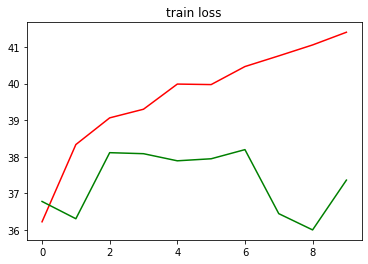

In [106]:
### FashionMINIST0.7 FashionCNN
def run_FashionCNN_2():
    global device
    global model
    global Fashion_model_2
    
    mean_train = 0
    mean_val = 0
    best_top1_acc = 0
    losses_train = []
    losses_val= []
    datatype = 1
    epoch = 10

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
    # set random seed
    seed_torch(1)

    # create output directory
    outdir = 'trained_model_4'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    # load data FashionMINIST0.6
    train_loader, val_loader= get_loader(
        batch_size = 100, 
        num_workers = 1,
        train_val_split = [0.8,0.2],
        data = Xtr_2,
        label = Ytr_2
    )

    # load test data FashionMINIST0.6
    test_data = DatasetArray(data = Xts_2, labels = Yts_2.tolist())
    test_loader = DataLoader(
        test_data,
        batch_size=100, 
        shuffle=True, 
        num_workers=1, 
    )

    ## FashionCNN
    Fashion_model_2 = FashionCNN()
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        Fashion_model = nn.DataParallel(Fashion_model_2)
    Fashion_model_2.to(device)


    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(  
        params = Fashion_model_2.parameters(),
        lr = 0.001, 
        momentum = 0.9,
        weight_decay = 2e-5
    )


    for epoch in range(epoch):

        print("epoch", epoch, ":")

        #train
        train_acc = train(epoch, Fashion_model_2, optimizer, criterion, train_loader)
        print("Train Accuracy ",train_acc)
        mean_train += train_acc

        #validation
        val_acc, s = validate_and_test(epoch, Fashion_model_2, criterion, val_loader, datatype=0)
        print("val Accuracy ",val_acc)
        mean_val += val_acc

        losses_train.append(train_acc)
        losses_val.append(val_acc)

        # save the best model so far
        if (val_acc > best_top1_acc):
            state = OrderedDict([
            #    ('config', config),
                ('state_dict', Fashion_model_2.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', val_acc),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = val_acc
    
    print("train mean:", mean_train/(epoch+1))
    print("val mean:", mean_val/(epoch+1))

    plt.title('train loss')
    plt.plot(np.arange(len(losses_train)), losses_train, color='red',label='train')
    plt.plot(np.arange(len(losses_val)),losses_val, color='green', label='val')  

    test_accurac, st = validate_and_test(1, Fashion_model_2, criterion, test_loader, datatype = 0)
    print("Test mean:",test_accurac) 
    print("Test standard: ", st.item() )

    test_accuracy, std = validate_and_test(1, Fashion_model_2, criterion, test_loader, datatype=2)
    print("Test:",test_accuracy)
    print("Test standard: ", std.item() )

run_FashionCNN_2()

In [107]:
eval_flip_rates(Fashion_model_2,"trained_model_4")

estimated negative flip rate： 0.2541327178478241
estimated positive flip rate： 0.5483614504337311


# **5 DATSET: CIFAR**

# **5.1 Dataloader**

In [108]:
# load data FashionMINIST0.5 
train_loader, val_loader= get_loader(
    batch_size = 100, 
    num_workers = 1,
    train_val_split = [0.8,0.2],
    data = Xtr_3,
    label = Ytr_3
)

# load test data FashionMINIST0.5
test_data = DatasetArray(data = Xts_3, labels = Yts_3.tolist())
test_loader = DataLoader(
    test_data,
    batch_size=100, 
    shuffle=True, 
    num_workers=1, 
)

for i, (d,l) in enumerate(train_loader):
  if i == 1:
    print(d.shape)
    print(l.shape)

torch.Size([100, 32, 32, 3])
torch.Size([100])


# **4.2 Two models** 

In [110]:
class DaiNet7(nn.Module): # 定义卷积神经网络
    def __init__(self):
        super(DaiNet7, self).__init__() 
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1), # 输出 32*32*64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1))

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1), # 输出 32*32*64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),		# 输出 16*16*64
            nn.Dropout(0.1))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),	 # 输出 16*16*128
            nn.ReLU(),
            nn.BatchNorm2d(128))

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, padding=1), # 输出 16*16*128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),		# 输出 8*8*128
            nn.Dropout(0.5))

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, padding=1), # 输出 8*8*256
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5))

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 3, padding=1), # 输出 8*8*256
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AvgPool2d(8, 8)) 	# 输出 1*1*256
        self.fc1 = nn.Linear(1 * 1 * 256, 3)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)

        x = x.reshape(-1, 1 * 1 * 256)  
        x = F.softmax(self.fc1(x))
        return x

In [111]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.reshape(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x)

# **4.3 Other userful functions**

In [112]:
def train(epoch, model, optimizer, criterion, train_loader):
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    # swith model to to train mode
    model.train()
    for step, (data, targets) in enumerate(train_loader):
        data = data.permute(0, 3, 1, 2)
        data = data.to(device)
        targets = targets.to(device)

        preds = model(data)
       # print(torch.argmax(preds,dim=1))

        loss = criterion(preds, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        [top1_acc] = accuracy(preds.data, targets.data, topk=(1,)) 
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

    return top1_acc_meter.avg
    
    
def validate_and_test(epoch, model, criterion, val_loader, datatype=1):
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    acc_list = []

    model.eval()
    for step, (data, targets) in enumerate(val_loader): 
        data = data.permute(0, 3, 1, 2)
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)

        # predict
        with torch.no_grad():
            preds = model(data).to(device)

        a = torch.argmax(preds[:,0])
        b = torch.argmax(preds[:,1])
        c = torch.argmax(preds[:,2])
        matrix_transpose = torch.stack((preds[a],preds[b],preds[c]),0).to(device)
        matrix_inverse = torch.inverse(matrix_transpose.T).to(device)

        # forward
        loss = criterion(preds, targets)
        
        if datatype == 0:
            [top1_acc] = accuracy(preds.data, targets.data, topk=(1,)) 
            
        if datatype == 1:
            preds_change = torch.mm(matrix_inverse, preds.T).T .to(device)
            [top1_acc] = accuracy(preds_change.data, targets.data, topk=(1,)) 
            
        # record accuary and cross entropy losss
        min_batch_size = data.size(0)   ## 144
        top1_acc_meter.update(top1_acc.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

        acc_list.append(top1_acc.item())
        std = torch.std(torch.Tensor(acc_list))

    return top1_acc_meter.avg, std



In [121]:
def eval_flip_rates_2(model= CNNmodel,name= "trained_model_1"):
    global config
    global train_loader

    model.load_state_dict(torch.load(os.path.join(name, 'model_best.pth'))["state_dict"])
    model.eval()
    pos_condition_p = []
    for step, (data, targets) in enumerate(train_loader):
        
        data = data.to(device)
        data = data.squeeze(1)
        data = data.permute(0, 3, 1, 2)
        labels = targets.numpy()

        with torch.no_grad():
            outputs = model(data)

        one_hot_labels = one_hot_embedding(targets,3).numpy()
        probs = F.softmax(outputs, dim=1).cpu().data.numpy()
        data = data.cpu().numpy()
        pos_condition_p += probs[:,1].tolist() 
        
    pos_condition_p = sorted(pos_condition_p)

    negative_flip_rate, positive_flip_rate = pos_condition_p[0], 1-pos_condition_p[-1]
    print('estimated negative flip rate：', est_neg_flip_rate)
    print('estimated positive flip rate：', est_pos_flip_rate)

# **5.4 The first classfier for CIFAR**

epoch 0 :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Accuracy  34.791666666666664
val Accuracy  36.0


epoch 1 :
Train Accuracy  36.09166666666667
val Accuracy  36.43333333333333


epoch 2 :
Train Accuracy  36.65833333333333
val Accuracy  37.56666666666667


epoch 3 :
Train Accuracy  37.40833333333333
val Accuracy  37.53333333333333


epoch 4 :
Train Accuracy  37.5
val Accuracy  38.266666666666666


epoch 5 :
Train Accuracy  37.725
val Accuracy  38.333333333333336


epoch 6 :
Train Accuracy  38.358333333333334
val Accuracy  37.43333333333333


epoch 7 :
Train Accuracy  38.358333333333334
val Accuracy  38.06666666666667


epoch 8 :
Train Accuracy  38.266666666666666
val Accuracy  38.3


epoch 9 :
Train Accuracy  38.44166666666667
val Accuracy  38.6


epoch 10 :
Train Accuracy  38.166666666666664
val Accuracy  37.7


epoch 11 :
Train Accuracy  38.55833333333333
val Accuracy  38.13333333333333


epoch 12 :
Train Accuracy  38.65
val Accuracy  38.7


epoch 13 :
Train Accuracy  38.35
val Accuracy  38.53333333333333


epoch 14 :
Train Acc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test mean: 65.16666666666667
Test standard:  tensor(3.9399)
Test mean: 66.2
Test standard:  tensor(3.8092)


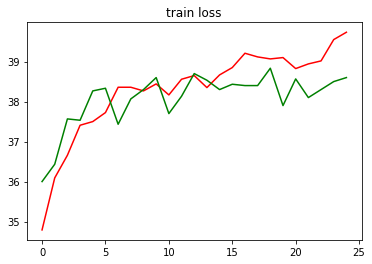

In [115]:
import torchvision.models as models
def Dainet():

    global device
    global Dainet

    mean_train = 0
    mean_val = 0
    best_top1_acc = 0
    losses_train = []
    losses_val= []
    datatype = 0
    epoch = 25

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'    
    
    # set random seed
    seed_torch(1)

    # create output directory
    outdir = 'trained_model_5'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    # Dainet
    Dainet = DaiNet7()
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        Dainet = nn.DataParallel(Dainet)
    Dainet.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(  
        params = Dainet.parameters(),
        lr = 0.001, 
        momentum = 0.9,
        weight_decay = 5e-4
    )

    for epoch in range(epoch):

        print("epoch", epoch, ":")

        #train
        train_acc = train(epoch, Dainet, optimizer, criterion, train_loader)
        print("Train Accuracy ",train_acc)
        mean_train += train_acc

        #validation
        val_acc, s = validate_and_test(epoch, Dainet, criterion, val_loader, datatype=0)
        print("val Accuracy ",val_acc)
        mean_val += val_acc

        losses_train.append(train_acc)
        losses_val.append(val_acc)

        print("\n")

        # save the best model so far
        if (val_acc > best_top1_acc):
            state = OrderedDict([
               # ('config', config),
                ('state_dict', Dainet.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', val_acc),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = val_acc

    print("train mean:", mean_train/(epoch+1))
    print("val mean:", mean_val/(epoch+1))

    plt.title('train loss')
    plt.plot(np.arange(len(losses_train)), losses_train, color='red',label='train')
    plt.plot(np.arange(len(losses_val)),losses_val, color='green', label='val') 

    test_accurac, st = validate_and_test(1, Dainet, criterion, test_loader, datatype=0)
    print("Test mean:",test_accurac) 
    print("Test standard: ", st )

    test_accuracy, std = validate_and_test(1, Dainet, criterion, test_loader, datatype=1)
    print("Test mean:",test_accuracy) 
    print("Test standard: ", std )
                
Dainet()


In [122]:
eval_flip_rates_2(Dainet,"trained_model_5")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


estimated negative flip rate： 0.2541327178478241
estimated positive flip rate： 0.5483614504337311


# **5.5 The second classfier for CIFAR**

epoch 0 :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Accuracy  33.575
val Accuracy  35.733333333333334


epoch 1 :
Train Accuracy  36.24166666666667
val Accuracy  34.96666666666667


epoch 2 :
Train Accuracy  36.53333333333333
val Accuracy  35.666666666666664


epoch 3 :
Train Accuracy  36.675
val Accuracy  36.36666666666667


epoch 4 :
Train Accuracy  37.825
val Accuracy  35.63333333333333


epoch 5 :
Train Accuracy  38.34166666666667
val Accuracy  35.733333333333334


epoch 6 :
Train Accuracy  37.983333333333334
val Accuracy  35.9


epoch 7 :
Train Accuracy  38.81666666666667
val Accuracy  37.1


epoch 8 :
Train Accuracy  38.3
val Accuracy  39.06666666666667


epoch 9 :
Train Accuracy  39.266666666666666
val Accuracy  36.63333333333333


train mean: 41.50648148148147
val mean: 40.31111111111111
Test mean: 54.333333333333336
Test standard:  tensor(4.3891)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test mean: 63.333333333333336
Test standard:  tensor(5.9500)


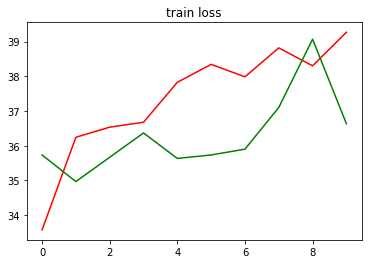

In [124]:
### CIFAR
def cnn():
    global net
    mean_train = 0
    mean_val = 0
    best_top1_acc = 0
    losses_train = []
    losses_val= []
    datatype = 0
    epoch = 10

    # check gpu
    device = 'cuda' if torch.cuda.is_available() else 'cpu'    
    
    # set random seed
    seed_torch(1)

    # create output directory
    outdir = 'trained_model_6'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    

    # CNNmodel
    net = CNN()
    if torch.cuda.device_count() > 1:
        print(torch.cuda.device_count(), "GPUs are used!")
        net = nn.DataParallel(net)
    net.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(  
        params = net.parameters(),
        lr = 0.001, 
        momentum = 0.9,
        weight_decay = 5e-4
    )

    for epoch in range(epoch):

        print("epoch", epoch, ":")

        #train
        train_acc = train(epoch, net, optimizer, criterion, train_loader)
        print("Train Accuracy ",train_acc)
        mean_train += train_acc

        #validation
        val_acc, s = validate_and_test(epoch, net, criterion, val_loader, datatype=0)
        print("val Accuracy ",val_acc)
        mean_val += val_acc

        losses_train.append(train_acc)
        losses_val.append(val_acc)

        print("\n")

        # save the best model so far
        if (val_acc > best_top1_acc):
            state = OrderedDict([
               # ('config', config),
                ('state_dict', net.state_dict()),
                ('optimizer', optimizer.state_dict()),
                ('epoch', epoch),
                ('top1-accuracy', val_acc),
            ])
            best_model_path = os.path.join(outdir, 'model_best.pth')
            torch.save(state, best_model_path)
            best_top1_acc = val_acc

    print("train mean:", mean_train/epoch)
    print("val mean:", mean_val/epoch)

    plt.title('train loss')
    plt.plot(np.arange(len(losses_train)), losses_train, color='red',label='train')
    plt.plot(np.arange(len(losses_val)),losses_val, color='green', label='val') 

    test_accurac, st = validate_and_test(1, net, criterion, test_loader, datatype=0)
    print("Test mean:",test_accurac) 
    print("Test standard: ", st)
    
    test_accuracy, std = validate_and_test(1, net, criterion, test_loader, datatype=1)
    print("Test mean:",test_accuracy) 
    print("Test standard: ", std) 
                
cnn()


In [125]:
eval_flip_rates_2(net,"trained_model_6")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


estimated negative flip rate： 0.2541327178478241
estimated positive flip rate： 0.5483614504337311
